# 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 2. Dataset & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [4]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [5]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# 3. Arsitektur & Config

In [6]:
from jcopdl.layers import conv_block, linear_block

In [7]:
class CustomCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
                       conv_block(3, 8),
                       conv_block(8, 16),
                       conv_block(16, 32),
                       conv_block(32, 64, pool_kernel=2, pool_stride=2),
                       nn.Flatten()
                       )
        
        self.fc = nn.Sequential(
                    linear_block(1024, 256, dropout=0.1), 
                    linear_block(256, 2, activation= 'lsoftmax')
                    )
        
    def forward (self, x):
        x = self.conv(x) #--> Data masuk ke feature extraction
        x = self.fc(x) #--> Data masuk ke fully connceted
        return x

In [8]:
config = set_config({
    'batch_size': bs,
    'crop_size':crop_size
})


# 4. Training Preparation -> MCOC

In [9]:
model = CustomCNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
callback = Callback(model, config, outdir='model')

# 5. Training Loop

In [10]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6928 | Test_cost  = 0.6896 | Train_score = 0.5180 | Test_score = 0.5025 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6846 | Test_cost  = 0.6678 | Train_score = 0.5460 | Test_score = 0.6900 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6299 | Test_cost  = 0.5963 | Train_score = 0.7060 | Test_score = 0.6750 |
==> EarlyStop patience =  1 | Best test_score: 0.6900


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5616 | Test_cost  = 0.5552 | Train_score = 0.7200 | Test_score = 0.7325 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5518 | Test_cost  = 0.5032 | Train_score = 0.7430 | Test_score = 0.7550 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5022 | Test_cost  = 0.4834 | Train_score = 0.7650 | Test_score = 0.7650 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4689 | Test_cost  = 0.4825 | Train_score = 0.7800 | Test_score = 0.7500 |
==> EarlyStop patience =  1 | Best test_score: 0.7650


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4505 | Test_cost  = 0.4679 | Train_score = 0.8000 | Test_score = 0.7600 |
==> EarlyStop patience =  2 | Best test_score: 0.7650


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4323 | Test_cost  = 0.4076 | Train_score = 0.8020 | Test_score = 0.8150 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4214 | Test_cost  = 0.3870 | Train_score = 0.8050 | Test_score = 0.8350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4354 | Test_cost  = 0.4656 | Train_score = 0.8140 | Test_score = 0.7675 |
==> EarlyStop patience =  1 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4313 | Test_cost  = 0.4596 | Train_score = 0.8100 | Test_score = 0.7750 |
==> EarlyStop patience =  2 | Best test_score: 0.8350


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4344 | Test_cost  = 0.3910 | Train_score = 0.7960 | Test_score = 0.8400 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3911 | Test_cost  = 0.3740 | Train_score = 0.8210 | Test_score = 0.8375 |
==> EarlyStop patience =  1 | Best test_score: 0.8400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3827 | Test_cost  = 0.3492 | Train_score = 0.8380 | Test_score = 0.8425 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3734 | Test_cost  = 0.3812 | Train_score = 0.8330 | Test_score = 0.8500 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3824 | Test_cost  = 0.3530 | Train_score = 0.8310 | Test_score = 0.8575 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3580 | Test_cost  = 0.3443 | Train_score = 0.8420 | Test_score = 0.8450 |
==> EarlyStop patience =  1 | Best test_score: 0.8575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3412 | Test_cost  = 0.3529 | Train_score = 0.8550 | Test_score = 0.8275 |
==> EarlyStop patience =  2 | Best test_score: 0.8575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3470 | Test_cost  = 0.3689 | Train_score = 0.8480 | Test_score = 0.8375 |


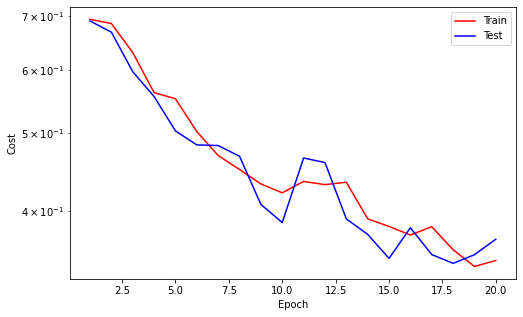

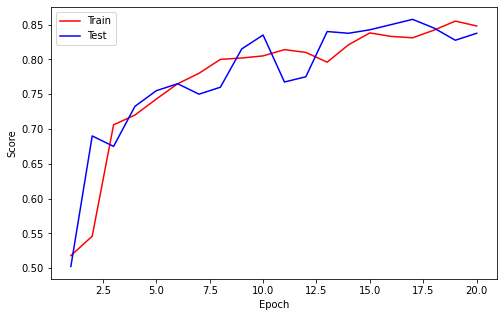

==> EarlyStop patience =  3 | Best test_score: 0.8575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3304 | Test_cost  = 0.3200 | Train_score = 0.8580 | Test_score = 0.8650 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3299 | Test_cost  = 0.3153 | Train_score = 0.8620 | Test_score = 0.8750 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3218 | Test_cost  = 0.3398 | Train_score = 0.8630 | Test_score = 0.8475 |
==> EarlyStop patience =  1 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3159 | Test_cost  = 0.3166 | Train_score = 0.8670 | Test_score = 0.8675 |
==> EarlyStop patience =  2 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3014 | Test_cost  = 0.3039 | Train_score = 0.8750 | Test_score = 0.8725 |
==> EarlyStop patience =  3 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.3173 | Test_cost  = 0.3295 | Train_score = 0.8690 | Test_score = 0.8650 |
==> EarlyStop patience =  4 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.3037 | Test_cost  = 0.2833 | Train_score = 0.8700 | Test_score = 0.8825 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.2959 | Test_cost  = 0.2966 | Train_score = 0.8720 | Test_score = 0.8875 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2846 | Test_cost  = 0.2687 | Train_score = 0.8900 | Test_score = 0.8925 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.2722 | Test_cost  = 0.2701 | Train_score = 0.8900 | Test_score = 0.8925 |
==> EarlyStop patience =  1 | Best test_score: 0.8925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.3094 | Test_cost  = 0.3077 | Train_score = 0.8710 | Test_score = 0.8650 |
==> EarlyStop patience =  2 | Best test_score: 0.8925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.2955 | Test_cost  = 0.3084 | Train_score = 0.8690 | Test_score = 0.8725 |
==> EarlyStop patience =  3 | Best test_score: 0.8925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.2861 | Test_cost  = 0.2769 | Train_score = 0.8810 | Test_score = 0.8900 |
==> EarlyStop patience =  4 | Best test_score: 0.8925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.2693 | Test_cost  = 0.2661 | Train_score = 0.8880 | Test_score = 0.9000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.2549 | Test_cost  = 0.2822 | Train_score = 0.8950 | Test_score = 0.8900 |
==> EarlyStop patience =  1 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.2559 | Test_cost  = 0.2863 | Train_score = 0.8900 | Test_score = 0.8750 |
==> EarlyStop patience =  2 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.2504 | Test_cost  = 0.2698 | Train_score = 0.9050 | Test_score = 0.8925 |
==> EarlyStop patience =  3 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.2434 | Test_cost  = 0.2456 | Train_score = 0.9060 | Test_score = 0.9075 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.2201 | Test_cost  = 0.2458 | Train_score = 0.9170 | Test_score = 0.9050 |
==> EarlyStop patience =  1 | Best test_score: 0.9075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.2204 | Test_cost  = 0.2409 | Train_score = 0.9090 | Test_score = 0.9100 |


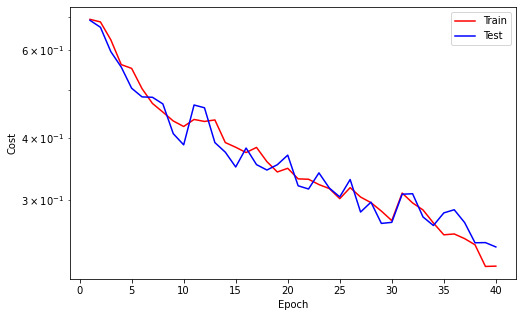

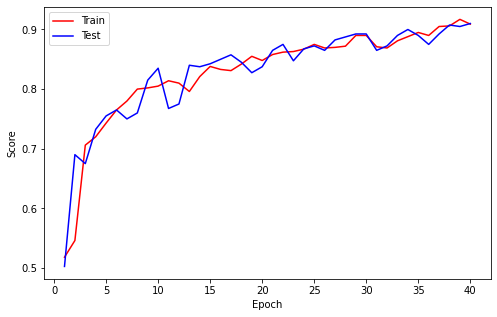

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.2281 | Test_cost  = 0.2585 | Train_score = 0.9030 | Test_score = 0.9025 |
==> EarlyStop patience =  1 | Best test_score: 0.9100


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.2357 | Test_cost  = 0.2261 | Train_score = 0.9000 | Test_score = 0.9125 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.2232 | Test_cost  = 0.2497 | Train_score = 0.9130 | Test_score = 0.8975 |
==> EarlyStop patience =  1 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.2241 | Test_cost  = 0.2348 | Train_score = 0.9080 | Test_score = 0.9025 |
==> EarlyStop patience =  2 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.2093 | Test_cost  = 0.2677 | Train_score = 0.9130 | Test_score = 0.8900 |
==> EarlyStop patience =  3 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.2037 | Test_cost  = 0.2267 | Train_score = 0.9190 | Test_score = 0.9100 |
==> EarlyStop patience =  4 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.1890 | Test_cost  = 0.2184 | Train_score = 0.9270 | Test_score = 0.9150 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.1903 | Test_cost  = 0.2171 | Train_score = 0.9270 | Test_score = 0.9150 |
==> EarlyStop patience =  1 | Best test_score: 0.9150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.1839 | Test_cost  = 0.2438 | Train_score = 0.9270 | Test_score = 0.9075 |
==> EarlyStop patience =  2 | Best test_score: 0.9150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.2051 | Test_cost  = 0.2103 | Train_score = 0.9200 | Test_score = 0.9150 |
==> EarlyStop patience =  3 | Best test_score: 0.9150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.2066 | Test_cost  = 0.2376 | Train_score = 0.9150 | Test_score = 0.9125 |
==> EarlyStop patience =  4 | Best test_score: 0.9150


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.1936 | Test_cost  = 0.2080 | Train_score = 0.9210 | Test_score = 0.9225 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.1694 | Test_cost  = 0.2141 | Train_score = 0.9230 | Test_score = 0.9225 |
==> EarlyStop patience =  1 | Best test_score: 0.9225


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.2054 | Test_cost  = 0.1933 | Train_score = 0.9230 | Test_score = 0.9300 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.1733 | Test_cost  = 0.2367 | Train_score = 0.9310 | Test_score = 0.9250 |
==> EarlyStop patience =  1 | Best test_score: 0.9300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.1674 | Test_cost  = 0.2188 | Train_score = 0.9310 | Test_score = 0.9125 |
==> EarlyStop patience =  2 | Best test_score: 0.9300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.1695 | Test_cost  = 0.2416 | Train_score = 0.9280 | Test_score = 0.9150 |
==> EarlyStop patience =  3 | Best test_score: 0.9300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.1747 | Test_cost  = 0.2182 | Train_score = 0.9270 | Test_score = 0.9400 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.1843 | Test_cost  = 0.2308 | Train_score = 0.9200 | Test_score = 0.9200 |
==> EarlyStop patience =  1 | Best test_score: 0.9400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.1704 | Test_cost  = 0.2149 | Train_score = 0.9330 | Test_score = 0.9250 |


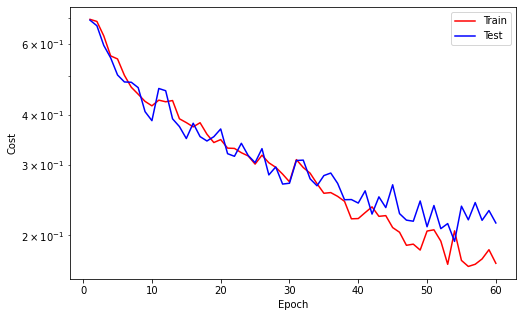

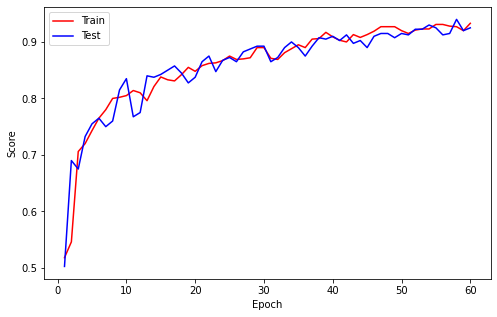

==> EarlyStop patience =  2 | Best test_score: 0.9400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.1673 | Test_cost  = 0.2046 | Train_score = 0.9250 | Test_score = 0.9175 |
==> EarlyStop patience =  3 | Best test_score: 0.9400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.1728 | Test_cost  = 0.2094 | Train_score = 0.9280 | Test_score = 0.9250 |
==> EarlyStop patience =  4 | Best test_score: 0.9400


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.1723 | Test_cost  = 0.2991 | Train_score = 0.9210 | Test_score = 0.9025 |
==> EarlyStop patience =  5 | Best test_score: 0.9400
==> Execute Early Stopping at epoch: 63 | Best test_score: 0.9400
==> Best model is saved at model


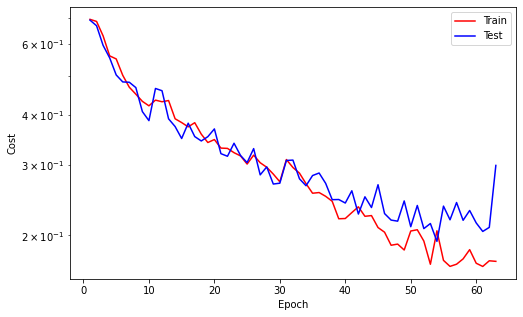

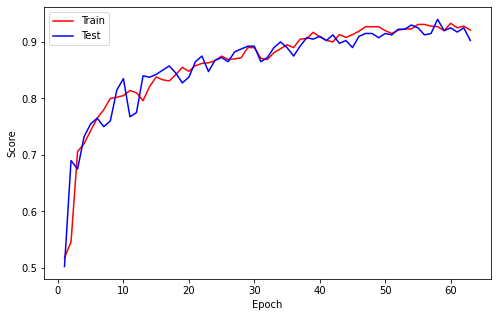

In [11]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# 6. Predict

In [12]:
#Sanity Check

feature, target = next(iter(testloader)) 
feature, target = feature.to(device), target.to(device) #Memindahkan ke gpu

In [13]:
with torch.no_grad():
    model.eval()
    
    output = model (feature)
    preds = output.argmax(0)

preds

tensor([63, 59], device='cuda:0')

In [14]:
with torch.no_grad():
    model.eval()
    
    output = model (feature)
    preds = output.argmax(1)

preds

tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')

# 7. Plot the result

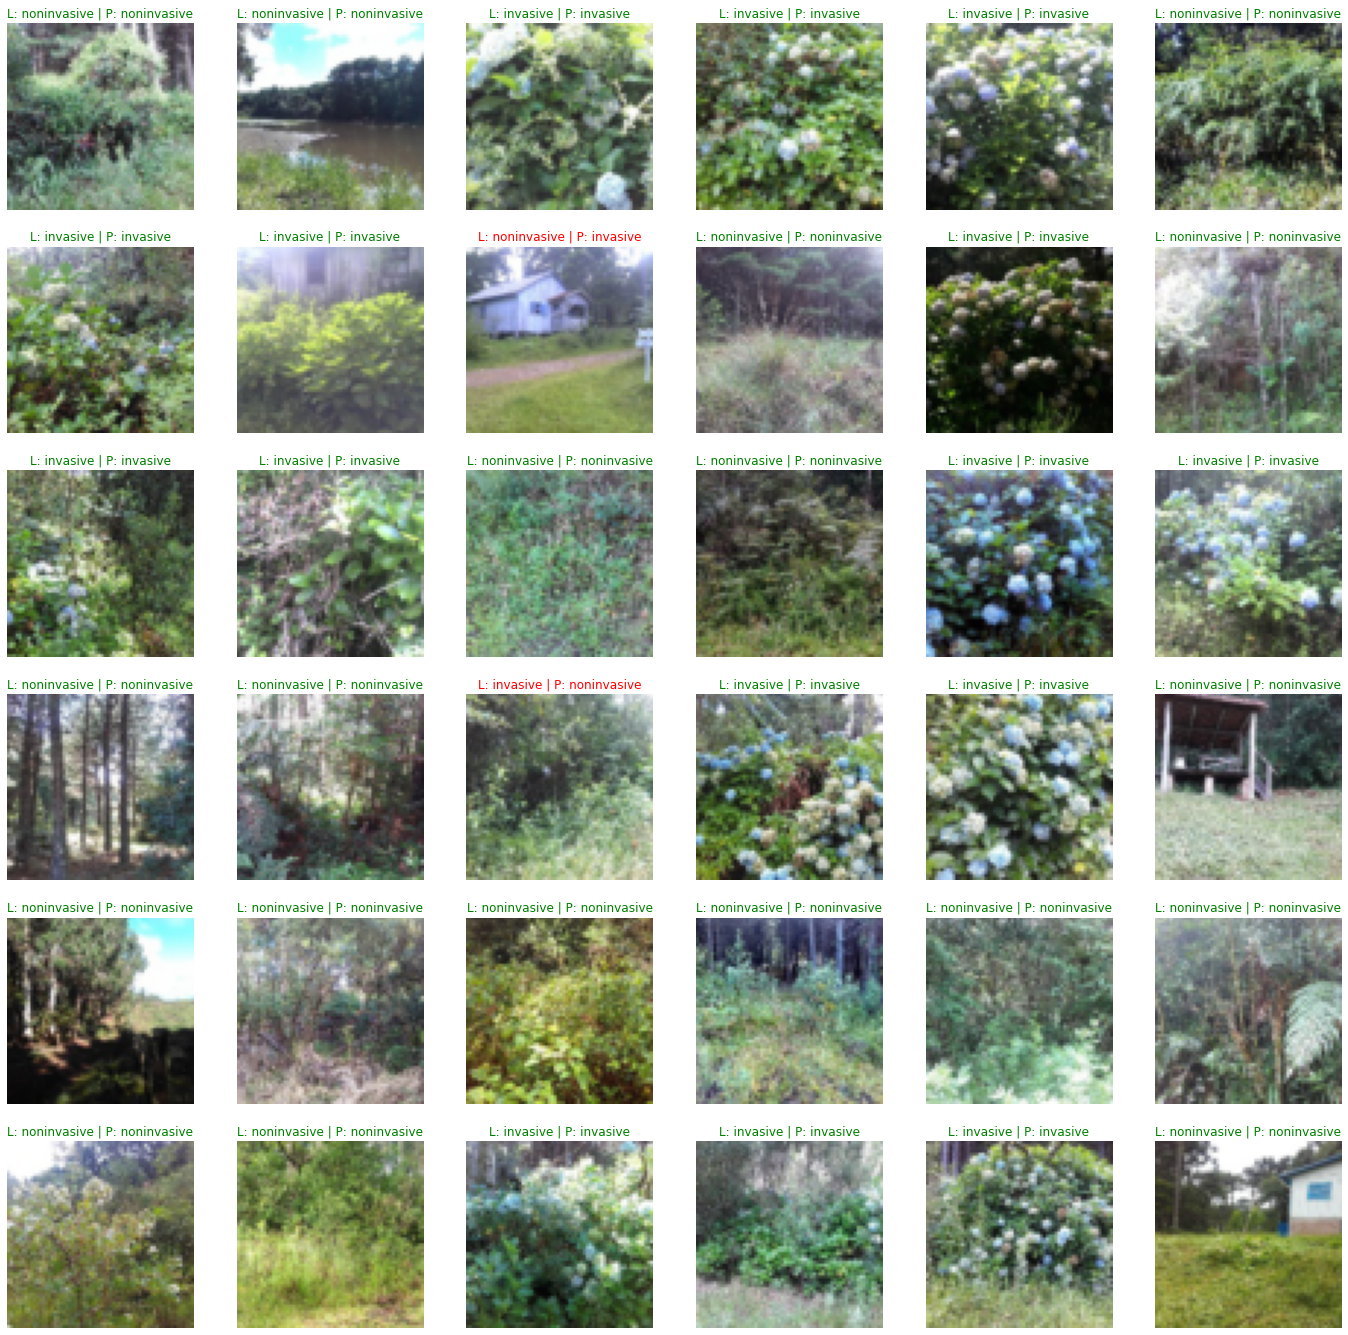

In [15]:
fig, axes = plt.subplots(6,6, figsize=(24,24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1,2,0).cpu())
    font = {'color':'r'} if label != pred else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'L: {label} | P: {pred}', fontdict = font);
    ax.axis('off');